# 04. _scMaui_ latent analysis

In this tutorial, we further investigate _scMaui_ results more focusing on the latents themselves. Again, the latents are assigned to the _anndata_ object.

In [21]:
from anndata import read_h5ad
import scanpy as sc
import pandas as pd

gex = read_h5ad("../data/GSE194122/gex_preprocessed.hdf5")
latents = pd.read_csv("../data/GSE194122/scmaui_latents.csv", sep="\t", index_col=0)
gex.obsm["scmaui"] = latents

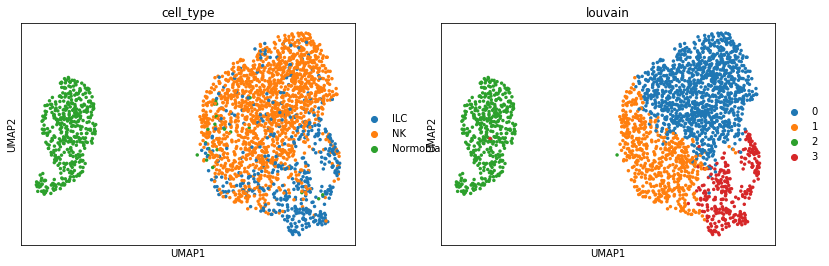

In [22]:
sc.pp.neighbors(gex, use_rep="scmaui")
sc.tl.umap(gex)
sc.tl.louvain(gex, resolution=0.3, key_added="louvain")
sc.pl.umap(gex, color=["cell_type", "louvain"])

### Latent value analysis

In the heatmap below, we plot normalised latent values together with cell-types and the clustering results produced in tutorial 03. 

/home/yuni/anaconda3/envs/scmaui/lib/python3.7/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


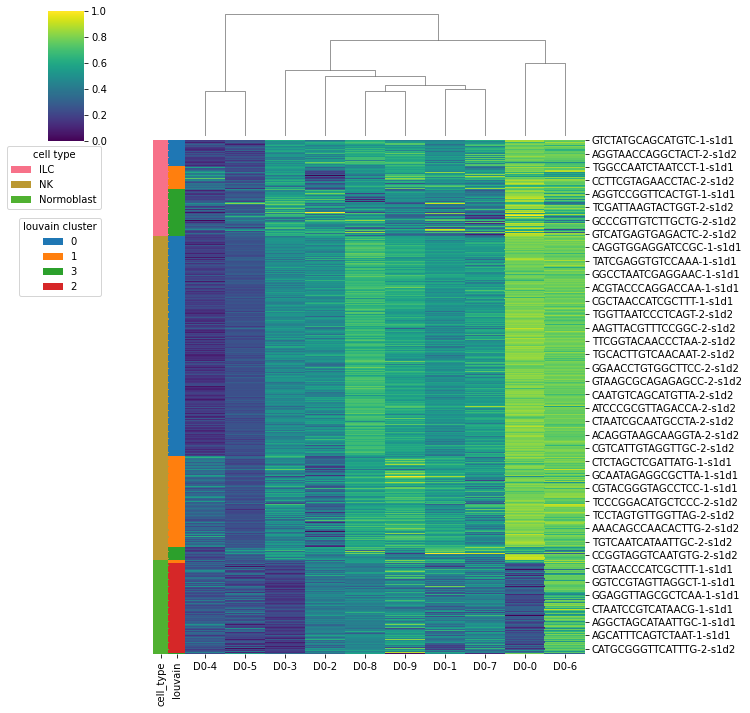

In [54]:
import seaborn as sns
import colorcet as cc
from matplotlib.patches import Patch
import matplotlib.pyplot as plt

latents["cell_type"] = gex.obs["cell_type"]
latents["louvain"] = gex.obs["louvain"]

latents = latents.sort_values(["cell_type", "louvain"])

lut = dict(zip(latents["cell_type"].unique(), sns.color_palette("husl")))
row_colors_1 = latents["cell_type"].astype(str).map(lut)
gt_handles_1 = [Patch(facecolor=lut[name]) for name in lut]

latents["louvain"] = latents["louvain"].astype(str)
lut2 = dict(zip(latents["louvain"].unique(), sns.color_palette("tab10")))
row_colors_2 = latents["louvain"].map(lut2)
gt_handles_2 = [Patch(facecolor=lut2[name]) for name in lut2]

row_colors = pd.concat([row_colors_1,row_colors_2],axis=1)


sns.clustermap(data=latents.drop(columns=["cell_type", "louvain"]), 
               row_colors=row_colors, row_cluster=False, cmap="viridis", standard_scale=1) 
l1 = plt.legend(gt_handles_1, lut, title='cell type', 
           bbox_to_anchor=(0.1, 0.8), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.gca().add_artist(l1)

plt.legend(gt_handles_2, lut2, title='louvain cluster', 
           bbox_to_anchor=(0.1, 0.7), bbox_transform=plt.gcf().transFigure, loc='upper right')
plt.show()

As latent D0-0 presents significantly low values in normoblast cells and D0-8 generally shows high values in NK cells, we plot these latent values by cell-types.

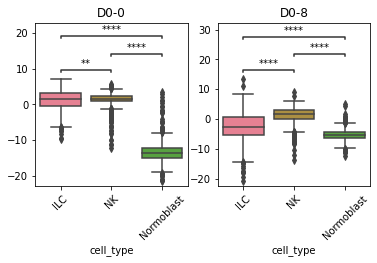

In [58]:
from statannot import add_stat_annotation

latents["cell_type"] = gex.obs["cell_type"]
latents["louvain"] = gex.obs["louvain"]
latents_numbers = [0, 8]
fig, ax = plt.subplots(1, len(latents_numbers), figsize=(6,3))
for j,i in enumerate(latents_numbers):
    
    sns.boxplot(data=latents, x="cell_type", y="D0-%d"%i, ax=ax[j], 
                palette=sns.color_palette("husl"))
    add_stat_annotation(ax[j], data=latents, x="cell_type", y="D0-%d"%i,
                        box_pairs=[("ILC", "NK"),
                                  ("ILC", "Normoblast"),
                                  ("NK", "Normoblast")
                                  ], 
                        test='t-test_ind', text_format='star', verbose=0)
    ax[j].set_title("D0-%d"%i)
    ax[j].set_ylabel(None)
    ax[j].set_xticklabels(ax[j].get_xticklabels(),rotation=45)


### Correlation between latents and gene expression

To analyse the information detected by individual latents, we firstly explore highly ranked genes in each cell-type.

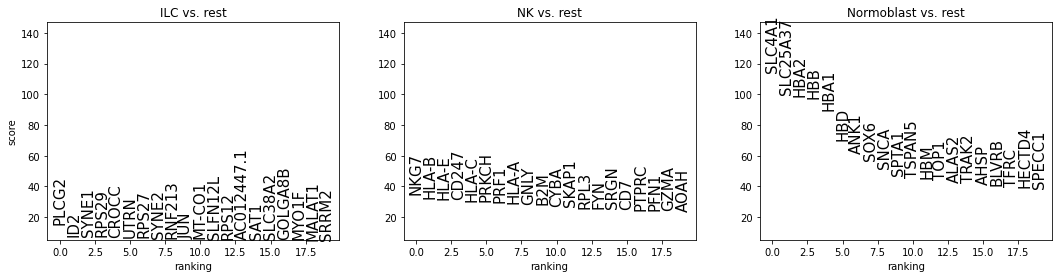

In [48]:
from itertools import chain
sc.tl.rank_genes_groups(adata = gex, groupby="cell_type")

sc.pl.rank_genes_groups(gex, fontsize=15)

Correlation between these genes and latents is calculated following the code below.

In [49]:
from tqdm.notebook import tqdm
rank_genes = list(chain(*gex.uns["rank_genes_groups"]["names"][:15]))

pd_list = list()
for i in tqdm(range(len(rank_genes))):
    a = gex.to_df().loc[:,rank_genes[i]].dropna()
    if len(a) > 2:
        b=pd.DataFrame(gex.obsm["scmaui"].loc[a.index,:].corrwith(a))
        b.columns=[rank_genes[i]]
        pd_list.append(b)
corr_matrix = pd.concat(pd_list,axis=1)
corr_matrix

  0%|          | 0/45 [00:00<?, ?it/s]

,PLCG2,NKG7,SLC4A1,ID2,HLA-B,SLC25A37,SYNE1,HLA-E,HBA2,RPS29,...,HBM,RPS12,RPL3,TOP1,AC012447.1,FYN,ALAS2,SAT1,SRGN,TRAK2
D0-0,0.301466,0.522652,-0.917120,0.415826,0.515576,-0.899632,0.532251,0.551991,-0.779054,0.291302,...,-0.786234,0.254277,0.418917,-0.707471,0.107858,0.508648,-0.806580,0.283871,0.512282,-0.805875
D0-1,0.002144,0.379758,-0.476177,0.129383,0.424700,-0.470439,0.191163,0.379504,-0.468626,0.099025,...,-0.421868,0.099832,0.407379,-0.336076,-0.010071,0.348158,-0.440933,0.023603,0.342684,-0.401102
D0-2,0.079761,0.359300,-0.160321,0.291998,0.348865,-0.168631,-0.060727,0.231141,-0.118583,0.302857,...,-0.098104,0.275977,0.394629,-0.153480,0.105067,-0.016670,-0.133438,0.136648,0.222899,-0.159330
D0-3,0.337075,0.370670,-0.817728,0.333744,0.379620,-0.810808,0.567401,0.423218,-0.667292,0.226334,...,-0.668088,0.191758,0.245599,-0.660583,0.118219,0.442541,-0.724874,0.256569,0.400503,-0.732382
D0-4,0.097709,-0.552621,0.188319,-0.251122,-0.433543,0.190812,-0.049695,-0.387312,0.154484,-0.264420,...,0.148406,-0.226586,-0.376416,0.132570,-0.010240,-0.076532,0.146384,-0.055748,-0.256280,0.193223
D0-5,0.104933,-0.060852,-0.044170,-0.017461,-0.061204,-0.031931,0.012079,-0.055251,0.058052,0.079629,...,-0.038677,0.075133,-0.066317,-0.040184,0.030502,-0.061110,-0.043166,-0.020313,-0.039200,-0.075908
D0-6,-0.114353,0.137290,-0.117142,0.048829,0.126810,-0.121333,0.124080,0.161764,-0.174346,-0.035666,...,-0.115881,-0.032224,0.078169,-0.060476,-0.054379,0.166020,-0.097048,0.030727,0.143225,-0.078856
D0-7,-0.186117,0.498600,-0.325783,0.061333,0.416440,-0.345709,0.269970,0.430669,-0.405477,0.020473,...,-0.272225,-0.021239,0.289719,-0.218329,-0.113973,0.345790,-0.295645,-0.055890,0.283748,-0.260327
D0-8,-0.201153,0.753868,-0.543483,0.216510,0.684327,-0.538252,0.198808,0.641093,-0.555629,0.231843,...,-0.471993,0.185115,0.622682,-0.372350,-0.146543,0.400722,-0.475839,0.000659,0.510100,-0.476582
D0-9,-0.127482,0.282981,-0.233523,0.051457,0.335026,-0.241846,0.052905,0.270288,-0.317571,-0.025142,...,-0.195342,-0.027557,0.336468,-0.166910,-0.061081,0.247579,-0.222227,0.014090,0.239641,-0.171607


We plot the correlation values in a heatmap plot again. D0-0 is negatively correlated with most of genes ranked in normoblast cells (HBB, HBA2, SLC4A1 and so on), which matches to the latent analysis above. Also, D0-8 shows positive correlation with most of ranked genes in NK cells such as NKG7 or HLA-B.

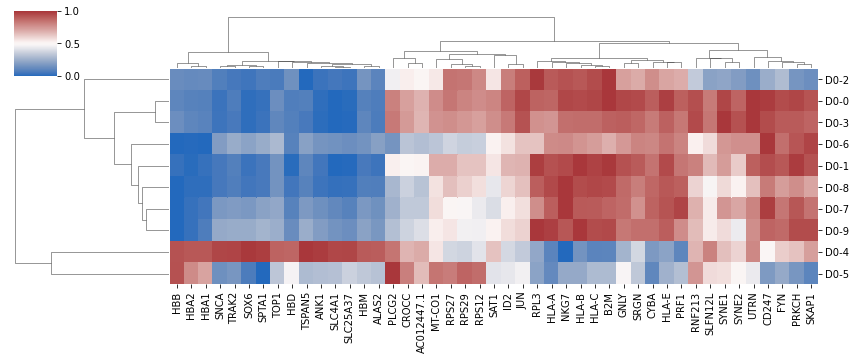

In [53]:
sns.clustermap(data=corr_matrix, row_cluster=True, cmap="vlag", 
               standard_scale=0, figsize=(12,5)) 


Interestignly, D0-5 is positively correlated with genes ranked in ILC and in normoblast. Therefore, we conduct an enrichment analysis with these genes using [_gseapy_](https://gseapy.readthedocs.io/en/latest/index.html). 

In [39]:
import gseapy as gp
gene_list = ["HBB", "HBA1", "HBA2", "PLCG2", "CROCC", "MT-CO1", "MT-CO1", 
             'RPS27', "RPS29", "RPS12", "RNF213"]
enr = gp.enrichr(gene_list=gene_list,
                 gene_sets=['GO_Cellular_Component_2021'],
                 organism='human', 
                 outdir=None, 
                )

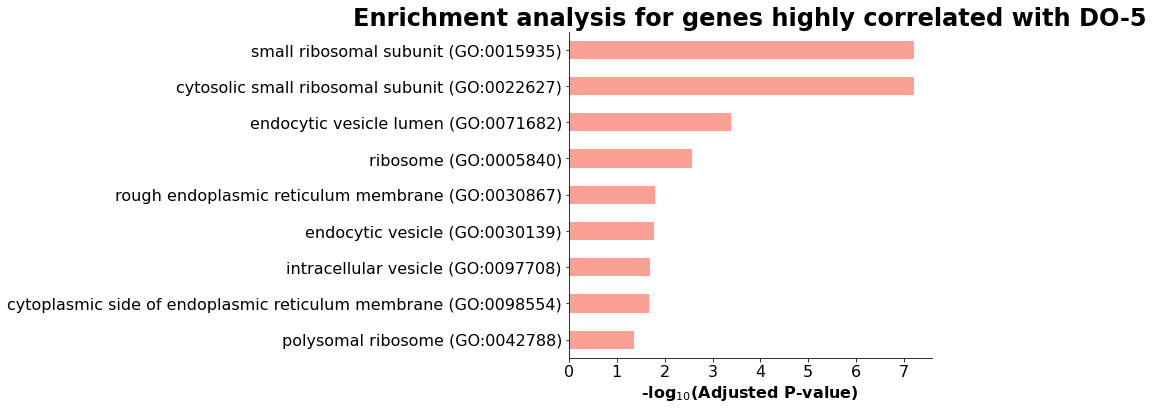

In [40]:
gp.barplot(enr.res2d,title = "Enrichment analysis for genes highly correlated with D0-5"
             )

The result describes that these genes are mostly related with ribosome and vesicle.

In [60]:
enr.results

,Gene_set,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes
0,GO_Cellular_Component_2021,cytosolic small ribosomal subunit (GO:0022627),4/40,2.854326e-09,6.042296e-08,0,0,369.518519,7270.066208,RPS27;RPS29;HBA1;RPS12
1,GO_Cellular_Component_2021,small ribosomal subunit (GO:0015935),4/45,4.647920e-09,6.042296e-08,0,0,324.373984,6223.713702,RPS27;RPS29;HBA1;RPS12
2,GO_Cellular_Component_2021,endocytic vesicle lumen (GO:0071682),2/21,4.701126e-05,4.074309e-04,0,0,262.776316,2618.598441,HBB;HBA1
3,GO_Cellular_Component_2021,ribosome (GO:0005840),2/62,4.187279e-04,2.721731e-03,0,0,83.041667,645.922108,RPS27;RPS29
4,GO_Cellular_Component_2021,rough endoplasmic reticulum membrane (GO:0030867),1/6,2.996578e-03,1.558221e-02,0,0,444.111111,2580.411794,RPS29
5,GO_Cellular_Component_2021,endocytic vesicle (GO:0030139),2/189,3.802922e-03,1.647933e-02,0,0,26.474599,147.516080,HBB;HBA1
6,GO_Cellular_Component_2021,intracellular vesicle (GO:0097708),1/11,5.487568e-03,2.038239e-02,0,0,222.000000,1155.569978,PLCG2
7,GO_Cellular_Component_2021,cytoplasmic side of endoplasmic reticulum memb...,1/13,6.482395e-03,2.106779e-02,0,0,184.981481,932.059746,RPS29
8,GO_Cellular_Component_2021,polysomal ribosome (GO:0042788),1/30,1.490236e-02,4.305125e-02,0,0,76.478927,321.688417,RPS29
9,GO_Cellular_Component_2021,tertiary granule lumen (GO:1904724),1/55,2.716803e-02,7.063688e-02,0,0,41.020576,147.908479,HBB
